<h1>Random Forest


Addestramento del modello con Random Forest utilizzando i dati ripuliti in 'training_c.csv'

Importazione delle librerie necessarie e del dataset

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,confusion_matrix)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


# Leggi il dataset
data = pd.read_csv('data/training_c.csv')

# Separa le feature (X) e la variabile target (y)
X = data.drop('RiskLevel', axis=1) 
y = data['RiskLevel']
data


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25.0,130,80.0,72.0,98.0,86.0,high risk
1,35.0,140,90.0,72.0,98.0,70.0,high risk
2,29.0,90,70.0,72.0,100.0,80.0,high risk
3,30.0,140,85.0,72.0,98.0,70.0,high risk
4,35.0,120,60.0,61.0,98.0,76.0,low risk
...,...,...,...,...,...,...,...
1004,48.0,120,80.0,72.0,98.0,88.0,high risk
1005,22.0,120,60.0,72.0,98.0,80.0,high risk
1006,55.0,120,90.0,72.0,98.0,60.0,high risk
1007,35.0,85,60.0,72.0,98.0,86.0,high risk


Divisione del dataset in training test e test set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Creazione e addestramento del modello Random Forest

In [15]:
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuratezza iniziale: {accuracy:.4f}")

# Calcolo dell'accuratezza con k-fold cross-validation (k=5)
accuracies = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Media e deviazione standard delle accuratezze
print(f"Accuratezza media con Cross-Validation: {accuracies.mean():.4f}")
print(f"Deviazione standard: {accuracies.std():.4f}")


Accuratezza iniziale: 0.8861
Accuratezza media con Cross-Validation: 0.8067
Deviazione standard: 0.0256


Ottimizzazione con GridSearch degli iperparametri: numero di alberi (n_estimators) e profondità massima degli alberi (max_dept)

In [16]:
# Definisci il range di parametri da testare
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Numero di alberi
    'max_depth': [None, 10, 20, 30, 50],  # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10, 20],  # Numero minimo di campioni per dividere un nodo
    'min_samples_leaf': [1, 2, 4, 8]  # Numero minimo di campioni in una foglia
}

# Inizializzazione GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # Numero di fold per la validazione incrociata
                           scoring='accuracy',
                           n_jobs=-1,
                           return_train_score=True)

# Addestramento del modello con la ricerca dei parametri ottimali
grid_search.fit(X_train, y_train)

# Miglior modello trovato
best_model = grid_search.best_estimator_
print(f"Migliori parametri trovati: {grid_search.best_params_}")


Migliori parametri trovati: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Valutazione del modello ottimizzato sul test set

In [ ]:
# Previsioni con il modello ottimizzato
y_pred_optimized = best_model.predict(X_test)

# Accuratezza
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Accuratezza: {accuracy_optimized:.4f}")


Accuratezza: 0.8812
Accuratezza media con Cross-Validation: 0.8104
Deviazione standard: 0.0222


In [18]:
# Stampa del classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

   high risk       0.91      0.93      0.92        54
    low risk       0.89      0.90      0.90        81
    mid risk       0.86      0.84      0.85        67

    accuracy                           0.89       202
   macro avg       0.89      0.89      0.89       202
weighted avg       0.89      0.89      0.89       202



Matrice di Confusione

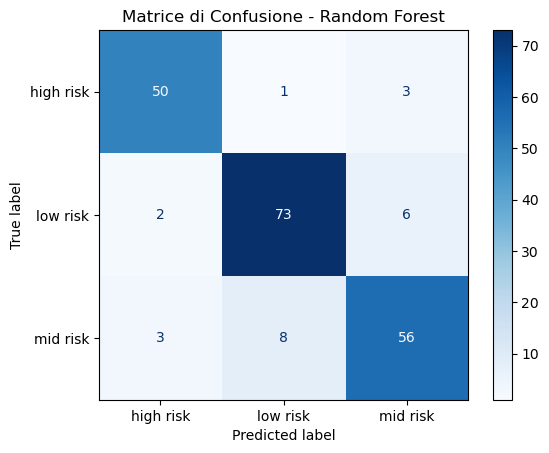

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
# Creazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Random Forest")
plt.show()

In [20]:

'''
# Nome delle classi (sostituisci con i tuoi nomi reali, se presenti)
class_names = np.unique(y)  # Usa i nomi delle classi se sono disponibili

# Visualizza la matrice di confusione migliorata
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Matrice di confusione')
plt.colorbar()

# Aggiungi etichette agli assi
plt.xlabel('Predizioni')
plt.ylabel('Valori reali')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

# Aggiungi i valori al centro di ogni quadrato
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black' if conf_matrix[i, j] < conf_matrix.max() / 2 else 'white')

plt.tight_layout()
plt.show()
'''

"\n# Nome delle classi (sostituisci con i tuoi nomi reali, se presenti)\nclass_names = np.unique(y)  # Usa i nomi delle classi se sono disponibili\n\n# Visualizza la matrice di confusione migliorata\nplt.figure(figsize=(8, 6))\nplt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')\nplt.title('Matrice di confusione')\nplt.colorbar()\n\n# Aggiungi etichette agli assi\nplt.xlabel('Predizioni')\nplt.ylabel('Valori reali')\nplt.xticks(np.arange(len(class_names)), class_names, rotation=45)\nplt.yticks(np.arange(len(class_names)), class_names)\n\n# Aggiungi i valori al centro di ogni quadrato\nfor i in range(conf_matrix.shape[0]):\n    for j in range(conf_matrix.shape[1]):\n        plt.text(j, i, conf_matrix[i, j], \n                 ha='center', va='center', color='black' if conf_matrix[i, j] < conf_matrix.max() / 2 else 'white')\n\nplt.tight_layout()\nplt.show()\n"

Realizzazione della **Curva di Apprendimento** 

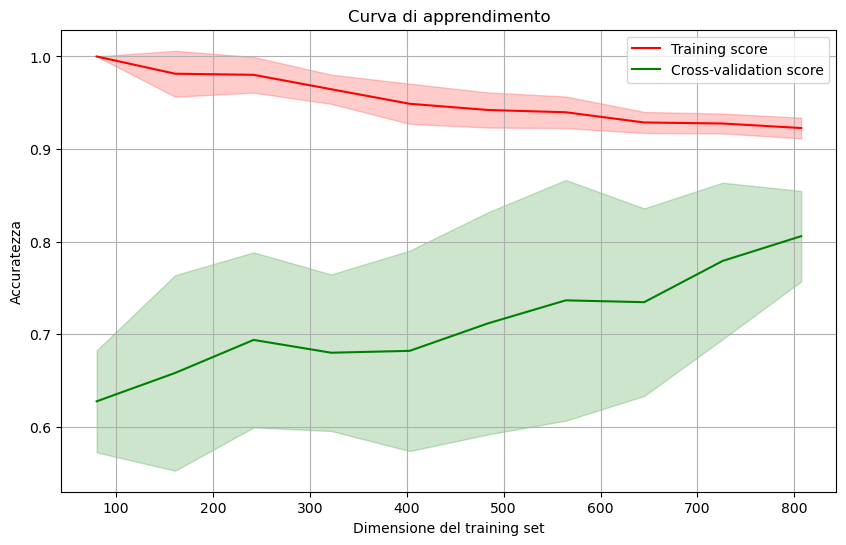

In [21]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy"
)
# Calcola medie e deviazioni standard
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Traccia la curva di apprendimento
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="r")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.title("Curva di apprendimento")
plt.xlabel("Dimensione del training set")
plt.ylabel("Accuratezza")
plt.legend(loc="best")
plt.grid()
plt.show()





Realizzazione della **Curva di Validazione**

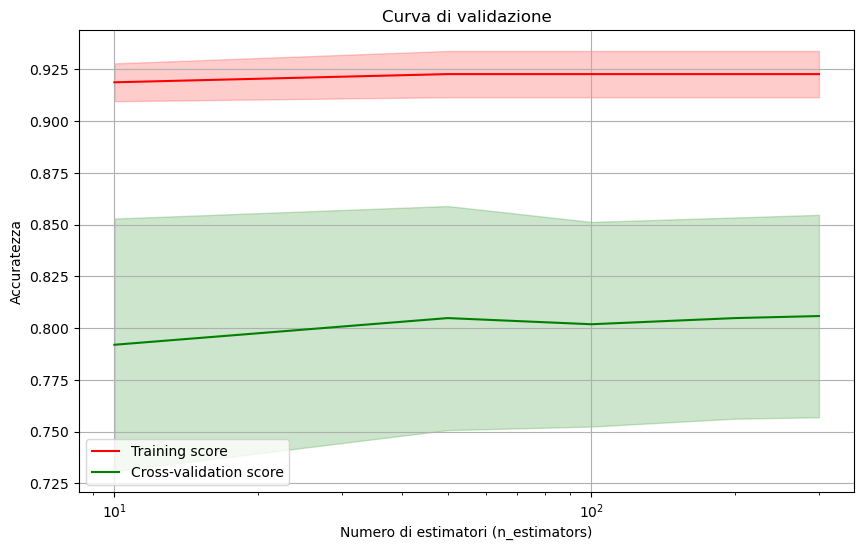

In [ ]:
from sklearn.model_selection import validation_curve
param_range = [10, 50, 100, 200, 300]  # Esempio per il parametro 'n_estimators'
train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42), X, y, param_name="n_estimators", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1
)

# Calcola medie e deviazioni standard
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Traccia la curva di validazione
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.title("Curva di validazione")
plt.xlabel("Numero di estimatori (n_estimators)")
plt.ylabel("Accuratezza")
plt.xscale("log")
plt.legend(loc="best")
plt.grid()
plt.show()

In [ ]:
'''
# Curva di validazione (Accuracy su validation e training set)
results = grid_search.cv_results_
mean_train_score = results['mean_train_score']
mean_test_score = results['mean_test_score']
param_combinations = range(len(mean_train_score))

plt.figure(figsize=(10, 6))
plt.plot(param_combinations, mean_train_score, label='Training Accuracy', marker='o')
plt.plot(param_combinations, mean_test_score, label='Validation Accuracy', marker='o')
plt.xlabel('Combinazione Parametri')
plt.ylabel('Accuracy')
plt.title('Curva di Validazione')
plt.legend()
plt.grid(True)
plt.show()
'''

"\n# Curva di validazione (Accuracy su validation e training set)\nresults = grid_search.cv_results_\nmean_train_score = results['mean_train_score']\nmean_test_score = results['mean_test_score']\nparam_combinations = range(len(mean_train_score))\n\nplt.figure(figsize=(10, 6))\nplt.plot(param_combinations, mean_train_score, label='Training Accuracy', marker='o')\nplt.plot(param_combinations, mean_test_score, label='Validation Accuracy', marker='o')\nplt.xlabel('Combinazione Parametri')\nplt.ylabel('Accuracy')\nplt.title('Curva di Validazione')\nplt.legend()\nplt.grid(True)\nplt.show()\n"